# Backend

In [1]:
%pip install transformers
%pip install torch
%pip install timm
%pip install flash_attn
%pip install einops
%pip install einops
%pip install requests

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 29.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 40.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for flash_attn: filename=flash_attn-2.6.3-cp310-cp310-linux_x86_64.whl size=187309225 sha256=237ef9c6157db394e1ddde4ba609a21ebb98382377a27041edc09318801a6f24
  Stored in directory: /root/.cache/pip/wheels/7e/e3/c3/89c7a2f3c4adc07cd1c675f8bb7b9ad4d18f64a72bccdfe826
Successfully built flash_attn


In [ ]:
import copy
import datetime
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import requests
import sys
import torch


from io import BytesIO
from torchvision import transforms
from PIL import Image, ImageDraw, ImageFont
from transformers import AutoProcessor, AutoModelForCausalLM
%matplotlib inline

## Model

In [ ]:
import torch
from transformers import AutoModelForCausalLM, AutoProcessor

def load_model_colab(model_id, precision='fp16', attention='flash_attention_2', lora=None):
    # Set device (prefer GPU if available)
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print(f"Using device: {device}")

    # Set precision type (reduce memory usage)
    dtype = {"bf16": torch.bfloat16, "fp16": torch.float16, "fp32": torch.float32}[precision]

    # Load model with specified precision and attention
    model = AutoModelForCausalLM.from_pretrained(model_id,
                                                 attn_implementation=attention,
                                                 device_map=device,
                                                 torch_dtype=dtype,
                                                 trust_remote_code=True).eval()

    # Load processor
    processor = AutoProcessor.from_pretrained(model_id, trust_remote_code=True)

    # Apply LoRA adapters if provided
    if lora:
        from peft import PeftModel
        model = PeftModel.from_pretrained(model, lora, trust_remote_code=True)

    return model, processor

# Example usage in Colab
model_id = 'microsoft/Florence-2-large'
model, processor = load_model_colab(model_id, precision='fp16', attention='flash_attention_2')


Using device: cuda


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/2.44k [00:00<?, ?B/s]

configuration_florence2.py:   0%|          | 0.00/15.1k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/Florence-2-large:
- configuration_florence2.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_florence2.py:   0%|          | 0.00/127k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/Florence-2-large:
- modeling_florence2.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


pytorch_model.bin:   0%|          | 0.00/1.54G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/51.0 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

processing_florence2.py:   0%|          | 0.00/46.4k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/Florence-2-large:
- processing_florence2.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


tokenizer_config.json:   0%|          | 0.00/34.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.10M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


#NGROK

In [2]:
!pip install pyngrok
from pyngrok import ngrok

# Set your authentication token here (replace 'your_token' with the actual token from ngrok.com)
ngrok.set_auth_token("2hJO6WiBiQ5oc32ujNXWNbEnUMk_2bUeHKWRxc48Cqm78Jesx")


In [11]:
import re

!pkill ngrok
# Start Ngrok tunnel on port 5000 (or the port your server is running on)
public_url = ngrok.connect(5000)

print(f"Public URL: {public_url}")

print(type(public_url))


def extract_first_url(text):
    url_pattern = r'https?://[^\s"]+'
    urls = re.findall(url_pattern, text)
    return urls[0] if urls else None


first_url = extract_first_url(str(public_url))
print("First URL:", first_url)


import requests
import json

def send_update_request(url, update_data, method="POST"):
  payload = json.dumps(update_data)
  headers = {'Content-Type': 'application/json'}

  try:
    response = requests.request(method, url, headers=headers, data=payload)
    response.raise_for_status()
    return response
  except requests.exceptions.RequestException as e:
    print(f"An error occurred: {e}")
    return None

update_url = "https://url-store-4bt0.onrender.com/update"
data = {"updated": "aaaaaa"}
post_response = send_update_request(update_url, update_data=data)

get_url = "https://url-store-4bt0.onrender.com/"
get_response = send_update_request(get_url, update_data, method="GET")

if post_response and post_response.status_code == 200:
  print("POST request successful!")
if get_response and get_response.status_code == 200:
  print("GET request successful!")


Public URL: NgrokTunnel: "https://9db8-34-125-159-171.ngrok-free.app" -> "http://localhost:5000"
<class 'pyngrok.ngrok.NgrokTunnel'>
First URL: https://9db8-34-125-159-171.ngrok-free.app
An error occurred: 400 Client Error: Bad Request for url: https://url-store-4bt0.onrender.com/update
GET request successful!


#Server

In [4]:
# Example Flask App
from flask import Flask
app = Flask(__name__)

@app.route("/")
def home():
    return "Hello, Ngrok is running!"


task_prompt = '<CAPTION_TO_PHRASE_GROUNDING>'

# results = florence2(task_prompt, text_input="Licence plate")
print("\033[1;31;34m")
# print(results)

# Run Flask app on port 5000
app.run(port=5000)



 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit
INFO:werkzeug:127.0.0.1 - - [29/Sep/2024 06:23:20] "GET / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [29/Sep/2024 06:23:21] "GET /favicon.ico HTTP/1.1" 404 -


#Captions

In [ ]:
task_prompt = ['<CAPTION>', '<DETAILED_CAPTION>', '<MORE_DETAILED_CAPTION>' ]
level = 0
image = ""
result = florence2(task_prompt[level], image_input=image)
text = result[task_prompt[level]]
print("\033[1;31;34m")
print(text)

#FingerPoint

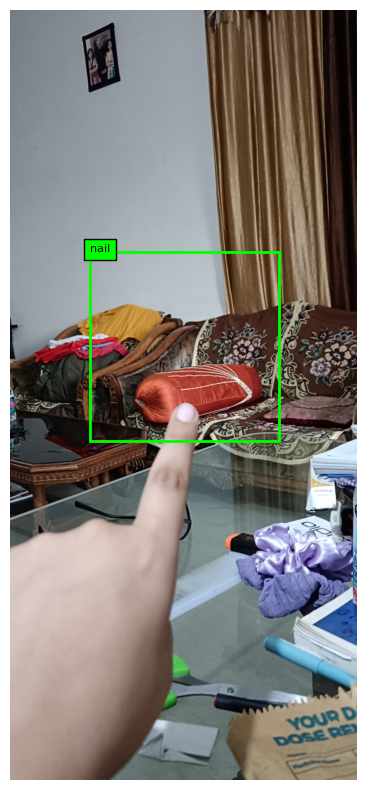

finger pointing at couch with floral patterned cushion


In [ ]:
image = "https://i.ibb.co/ZVTpFvq/IMG-20240928-170905.jpg"


def get_min_y_coordinate(nested_dict):
    polygon = nested_dict['<REFERRING_EXPRESSION_SEGMENTATION>']['polygons'][0][0]
    min_y = min(polygon[1::2])
    return polygon[polygon.index(min_y) - 1], min_y


def create_bounding_box(coords, image_size, box_percentage=0.1, shifter=0):
    width, height = image_size
    box_size = int(min(width, height) * box_percentage)
    x, y = coords
    half_size = box_size / 2
    return (x - half_size, y - box_size + shifter, x + half_size, y + shifter)


def calculate_box_above_center_point(x1, y1, x2, y2):
    box_size = x2 - x1
    center_x = (x1 + x2) / 2
    box_y1, box_y2 = y1 - box_size, y1
    box_x1, box_x2 = center_x - box_size / 2, center_x + box_size / 2
    return f"<loc_{int(box_x1)}><loc_{int(box_y1)}><loc_{int(box_x2)}><loc_{int(box_y2)}>"


task_prompt = '<REFERRING_EXPRESSION_SEGMENTATION>'
results = florence2(task_prompt, text_input="finger", image_input=image)

min_value = get_min_y_coordinate(results)
bbox = create_bounding_box(min_value, 1000, shifter=200)
plot_bbox(load_image(image), {'bboxes':[bbox],'labels':['object']})

box_coords = calculate_box_above_center_point(*bbox)
results = florence2('<REGION_TO_DESCRIPTION>', text_input=box_coords, image_input=image)

print(list(results.values())[0].split('<loc_')[0].strip())

#Read Text

In [ ]:
task_prompt = '<OCR>'
image = "https://cdn.collectorbazar.com/products/a2zkollection-india-complete-4-pages-document-on-king-george-kgvi-1-rs-stamp-paper-used-for-english-document-sp203sd-455701-2.jpg"
text = florence2(task_prompt, image_input=image)
# print(text)
print(text['<OCR>'])

Merchant residing at 1, Raja Raj Balav Street in the town of -Calcutta aforesaid Dr. SANT BHUSAN DUTT son of Kalash ChandraDutt deceased residing at 12 Earle Street son of the town in -Dutt decreased residing at the 12 Earlle Street in The town ofKalcutta by caste Baidya Service-holder PEARLY MUKHERITES -Son of Dr. Balakumha Nath Muharjee deceased deceased by caste Brahminby occupation Merchant residing at No. 2A Harra Mohan Road in thetown of Calcutta GURU GOBINDA BASH son of 4A Mahindi Mohan Basu ---deceased by caste Kayaseta by occupation merchant residing at -No. 16/4/4 Garlakat Road sin in the Town of Calicuta by Dr.SATYA -CHURN LAW of Ambla Churn Law deceased residing in No. 50 -Kallash Bose Street on the town to Calcuttia by caste Subbara-Bank by occupation Merchant, Trustees under the Deed of No. Trust(being dated 13th August 1946 and made between the Deed of the BengalNational Chamber of Commerce of the First Part between the said Dr.......Narendra Nath Law of the Second Part 

#OpenSearch

In [ ]:
def convert_to_od_format(data):
    bboxes = data.get('bboxes', [])
    labels = data.get('bboxes_labels', [])
    od_results = {'bboxes': bboxes, 'labels': labels}

    return od_results

task_prompt = '<OPEN_VOCABULARY_DETECTION>'
image = "https://images.wsj.net/im-409476/SQUARE"

results = florence2(task_prompt, text_input="christmas tree shops", image_input=image)
print("\033[1;31;34m")

bbox_results = convert_to_od_format(results['<OPEN_VOCABULARY_DETECTION>'])
print(bbox_results)


{'bboxes': [[0.6389999985694885, 0.6389999985694885, 1276.0830078125, 1166.175048828125]], 'labels': ['christmas tree shops']}


#Object Detection


[0.9179999828338623, 2070.599853515625, 1014.3899536132812, 4073.8798828125]


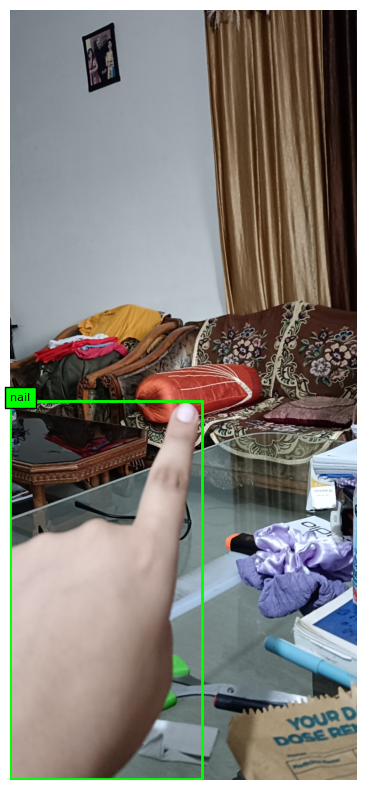


{'<REGION_TO_DESCRIPTION>': 'scissors<loc_457><loc_872><loc_557><loc_913>'}


In [ ]:
task_prompt = '<CAPTION_TO_PHRASE_GROUNDING>'

image = "https://i.ibb.co/ZVTpFvq/IMG-20240928-170905.jpg"

user_input = "fingernail"
results = florence2(task_prompt, text_input=user_input, image_input=image)
print("\033[1;31;34m")
# print(results)


results['<CAPTION_TO_PHRASE_GROUNDING>'][]




In [ ]:
{'<CAPTION_TO_PHRASE_GROUNDING>': {'bboxes': [[582.75, 567.5, 669.75, 662.5], [1098.75, 593.5, 1209.75, 659.5], [663.75, 573.5, 747.75, 661.5], [974.25, 584.5, 1064.25, 658.5], [1050.75, 599.5, 1116.75, 659.5]], 'labels': ['pillow', 'pillow', 'pillow', 'pillow', 'pillow']}}

In [ ]:
bboxes = data['<CAPTION_TO_PHRASE_GROUNDING>']['bboxes']
labels = data['<CAPTION_TO_PHRASE_GROUNDING>']['labels']

# Use zip to map bboxes with labels
mapped_data = list(zip(bboxes, labels))

print(mapped_data)

#Some

## Helper functions

In [ ]:
def calculate_bbox_center(bbox):
    x1, y1, x2, y2 = bbox
    center_x = (x1 + x2) / 2
    center_y = (y1 + y2) / 2
    return center_x, center_y

In [ ]:
def load_image(image_input):
    """
    Load an image from a file path or a URL.
    """
    if image_input.startswith('http://') or image_input.startswith('https://'):
        # Load image from URL
        response = requests.get(image_input)
        image = Image.open(BytesIO(response.content)).convert("RGB")
    else:
        # Load image from file path
        image = Image.open(image_input).convert("RGB")

    return image

In [ ]:
def florence2(task_prompt, text_input=None, image_input=None):
    """
    Calling the Microsoft Florence2 model with an image from a file path or URL.
    """
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model.to(device)

    if text_input is None:
        prompt = task_prompt
    else:
        prompt = task_prompt + text_input

    # Load the image
    image = load_image(image_input) if image_input else None

    # Process the input
    inputs = processor(text=prompt, images=image, return_tensors="pt")

    # Move the input tensors to the correct device
    inputs['input_ids'] = inputs['input_ids'].to(device)  # Ensure input_ids remain in default precision
    inputs['pixel_values'] = inputs['pixel_values'].to(device).half()  # Convert pixel_values to fp16

    # Generate text using the model
    generated_ids = model.generate(
        input_ids=inputs["input_ids"],
        pixel_values=inputs["pixel_values"],
        max_new_tokens=1024,
        early_stopping=False,
        do_sample=False,
        num_beams=3,
    )

    # Decode and post-process the generated output
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]
    parsed_answer = processor.post_process_generation(
        generated_text,
        task=task_prompt,
        image_size=(image.width, image.height) if image else (None, None)
    )

    return parsed_answer

In [ ]:
def plot_bbox(image, data):
    """
    Plot BBox
    """
    fig, ax = plt.subplots(figsize=(15, 10))
    ax.imshow(image)

    for bbox, label in zip(data['bboxes'], data['labels']):
        x1, y1, x2, y2 = bbox
        rect = patches.Rectangle((x1, y1),
                                 x2 - x1,
                                 y2 - y1,
                                 linewidth=2,
                                 edgecolor='lime',
                                 facecolor='none')
        ax.add_patch(rect)
        plt.text(x1,
                 y1,
                 label,
                 color='black',
                 fontsize=8,
                 bbox=dict(facecolor='lime', alpha=1))

    ax.axis('off')
    plt.show()

In [ ]:
def convert_to_od_format(data):
    """
    Converts a dictionary with 'bboxes' and 'bboxes_labels' into a dictionary with separate 'bboxes' and 'labels' keys.
    Parameters:
    - data: The input dictionary with 'bboxes', 'bboxes_labels', 'polygons', and 'polygons_labels' keys.
    Returns:
    - A dictionary with 'bboxes' and 'labels' keys formatted for object detection results.
    """
    bboxes = data.get('bboxes', [])
    labels = data.get('bboxes_labels', [])
    od_results = {'bboxes': bboxes, 'labels': labels}

    return od_results

## 1. Image

In [ ]:
image = Image.open(requests.get(url, stream=True).raw)

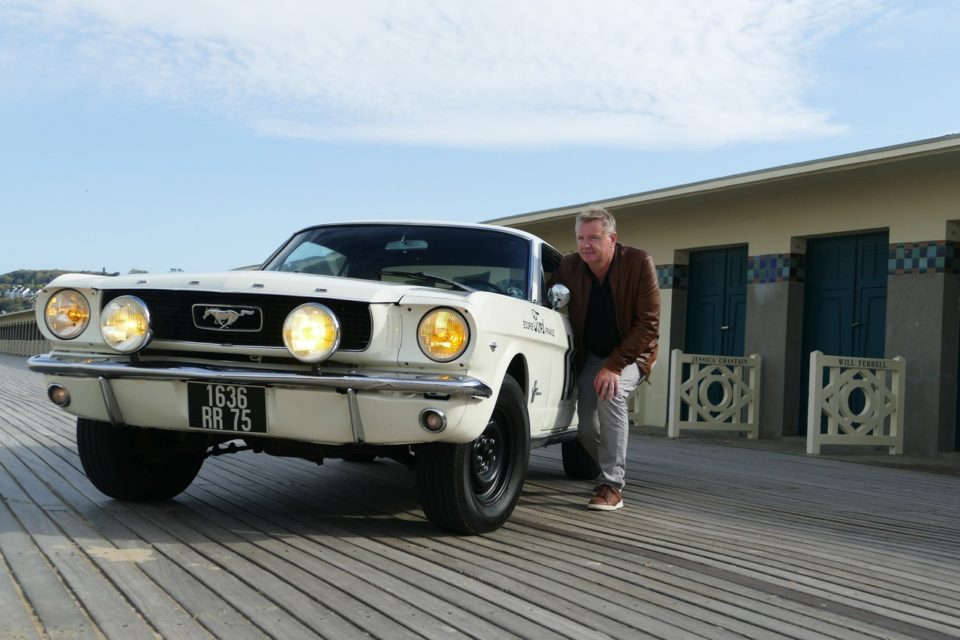

In [ ]:
url = "https://github.com/retkowsky/images/blob/master/car.jpg?raw=true"

image = Image.open(requests.get(url, stream=True).raw)
image

## 2. Run pre-defined tasks without additional inputs

### 2.1 Captions

In [ ]:
task_prompt = ['<CAPTION>', '<DETAILED_CAPTION>', '<MORE_DETAILED_CAPTION>' ]
level = 1
result = florence2(task_prompt[level-1])
print("\033[1;31;34m")
print(result)

### 2.2 Object detection

OD results format:
{'\<OD>':
    {
    'bboxes': [[x1, y1, x2, y2], ...],
    'labels': ['label1', 'label2', ...]
    }
}

In [ ]:
task_prompt = '<OD>'

results = florence2(task_prompt)
print("\033[1;31;34m")
print(results)


{'<OD>': {'bboxes': [[805.9199829101562, 350.3999938964844, 905.760009765625, 455.3599853515625], [720.47998046875, 326.0799865722656, 730.0799560546875, 329.91998291015625], [281.7599792480469, 302.3999938964844, 340.32000732421875, 363.1999816894531], [99.36000061035156, 295.3599853515625, 152.16000366210938, 352.9599914550781], [416.1600036621094, 307.5199890136719, 469.91998291015625, 362.55999755859375], [43.68000030517578, 288.9599914550781, 90.72000122070312, 339.5199890136719], [544.7999877929688, 207.67999267578125, 661.9199829101562, 511.67999267578125], [547.6799926757812, 283.8399963378906, 570.719970703125, 310.0799865722656], [25.439998626708984, 219.1999969482422, 600.47998046875, 535.3599853515625], [186.72000122070312, 381.7599792480469, 267.3599853515625, 432.9599914550781], [380.6399841308594, 270.3999938964844, 477.5999755859375, 292.1600036621094]], 'labels': ['chair', 'door handle', 'headlight', 'headlight', 'headlight', 'headlight', 'person', 'rearview mirror', 

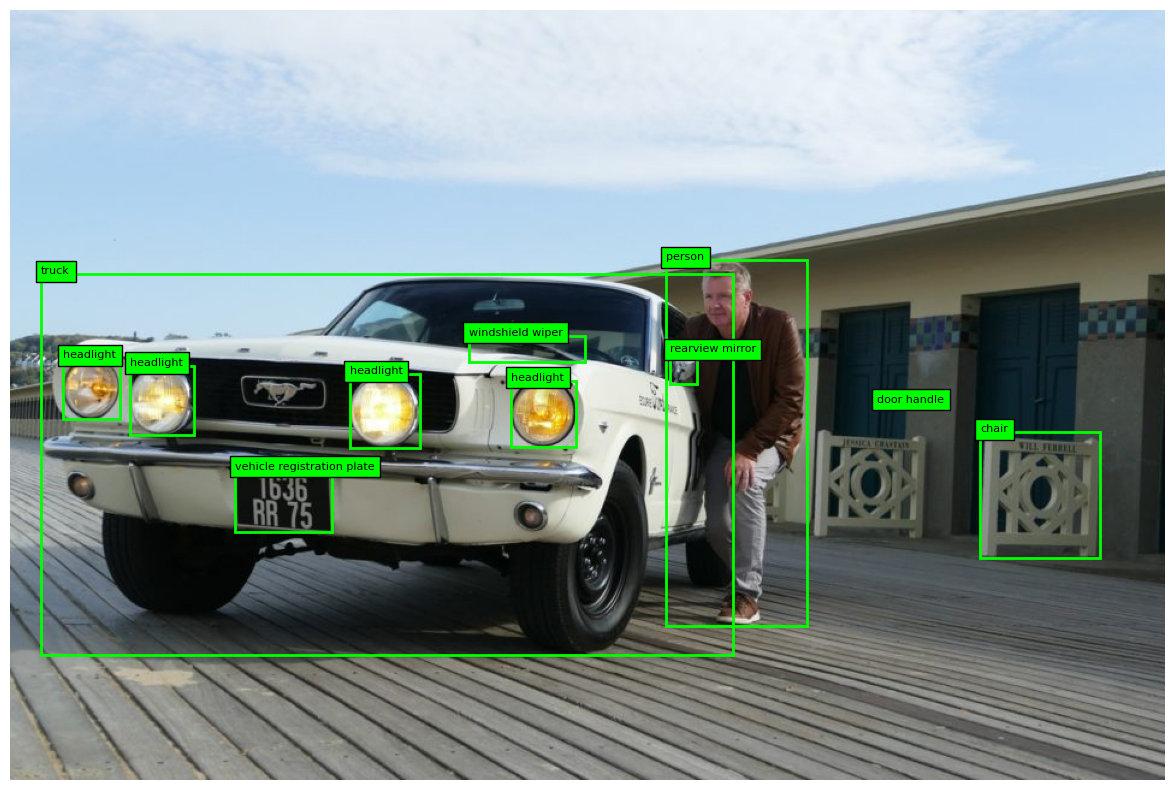

In [ ]:
plot_bbox(image, results['<OD>'])

### 2.3 Dense region caption

Dense region caption results format:
{'\<DENSE_REGION_CAPTION>': {'bboxes': [[x1, y1, x2, y2], ...], 'labels': ['label1', 'label2', ...]}}

In [ ]:
task_prompt = '<DENSE_REGION_CAPTION>'

results = florence2(task_prompt)
print("\033[1;31;34m")
print(results)


{'<DENSE_REGION_CAPTION>': {'bboxes': [[25.439998626708984, 219.1999969482422, 600.47998046875, 535.3599853515625], [544.7999877929688, 207.67999267578125, 661.9199829101562, 511.67999267578125], [805.9199829101562, 350.3999938964844, 905.760009765625, 455.3599853515625], [186.72000122070312, 381.7599792480469, 267.3599853515625, 432.9599914550781], [281.7599792480469, 302.3999938964844, 340.32000732421875, 363.1999816894531], [99.36000061035156, 295.3599853515625, 152.16000366210938, 352.9599914550781], [416.1600036621094, 307.5199890136719, 469.91998291015625, 362.55999755859375], [43.68000030517578, 288.9599914550781, 90.72000122070312, 339.5199890136719], [546.719970703125, 283.8399963378906, 570.719970703125, 310.0799865722656], [720.47998046875, 326.0799865722656, 730.0799560546875, 329.91998291015625]], 'labels': ['1968 Ford Mustang Fastback restoration project', 'man with vintage car on wooden deck', 'white wooden gate with circular design', 'vehicle registration plate', 'head

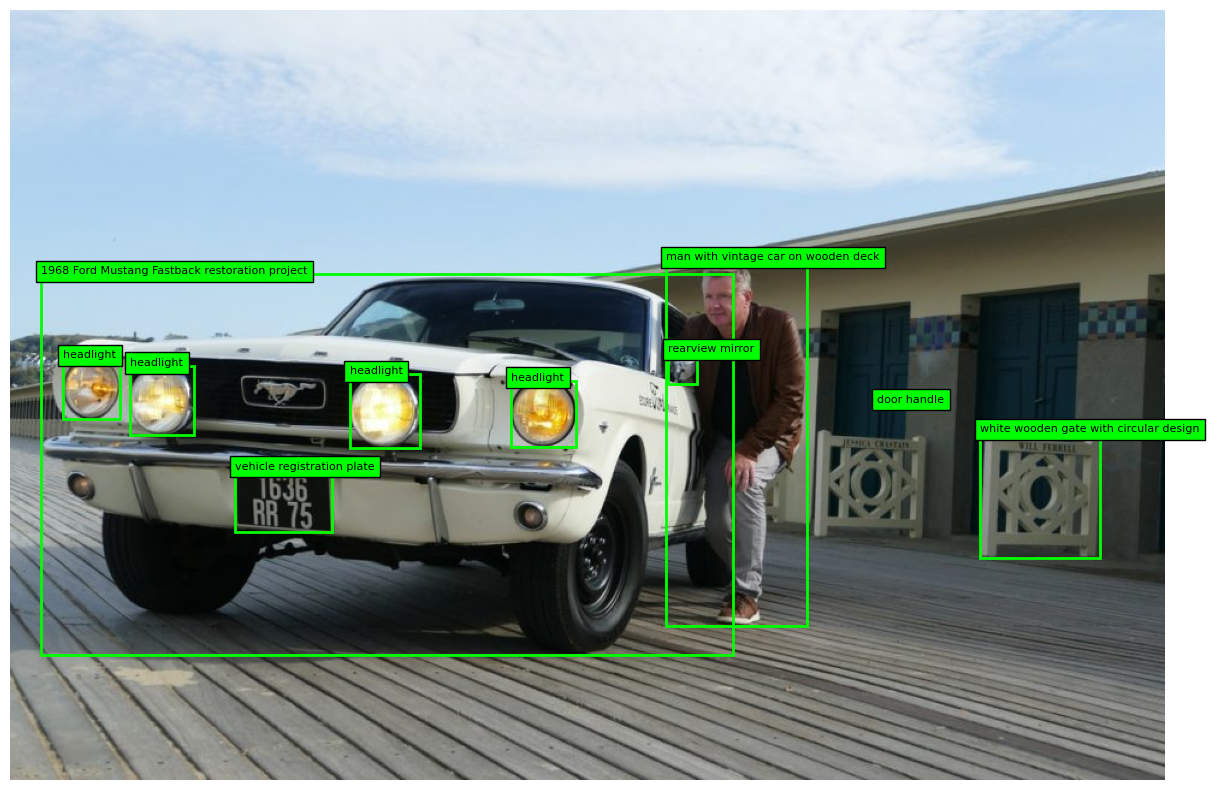

In [ ]:
plot_bbox(image, results['<DENSE_REGION_CAPTION>'])

## 3. Run pre-defined tasks that requires additional inputs

### 3.1 Phrase Grounding
Phrase grounding results format:
{'\<CAPTION_TO_PHRASE_GROUNDING>': {'bboxes': [[x1, y1, x2, y2], ...], 'labels': ['', '', ...]}}

In [ ]:
task_prompt = '<CAPTION_TO_PHRASE_GROUNDING>'

results = florence2(task_prompt, text_input="Licence plate")
print("\033[1;31;34m")
print(results)


{'<CAPTION_TO_PHRASE_GROUNDING>': {'bboxes': [[185.75999450683594, 379.1999816894531, 268.32000732421875, 434.8800048828125]], 'labels': ['Licence plate']}}


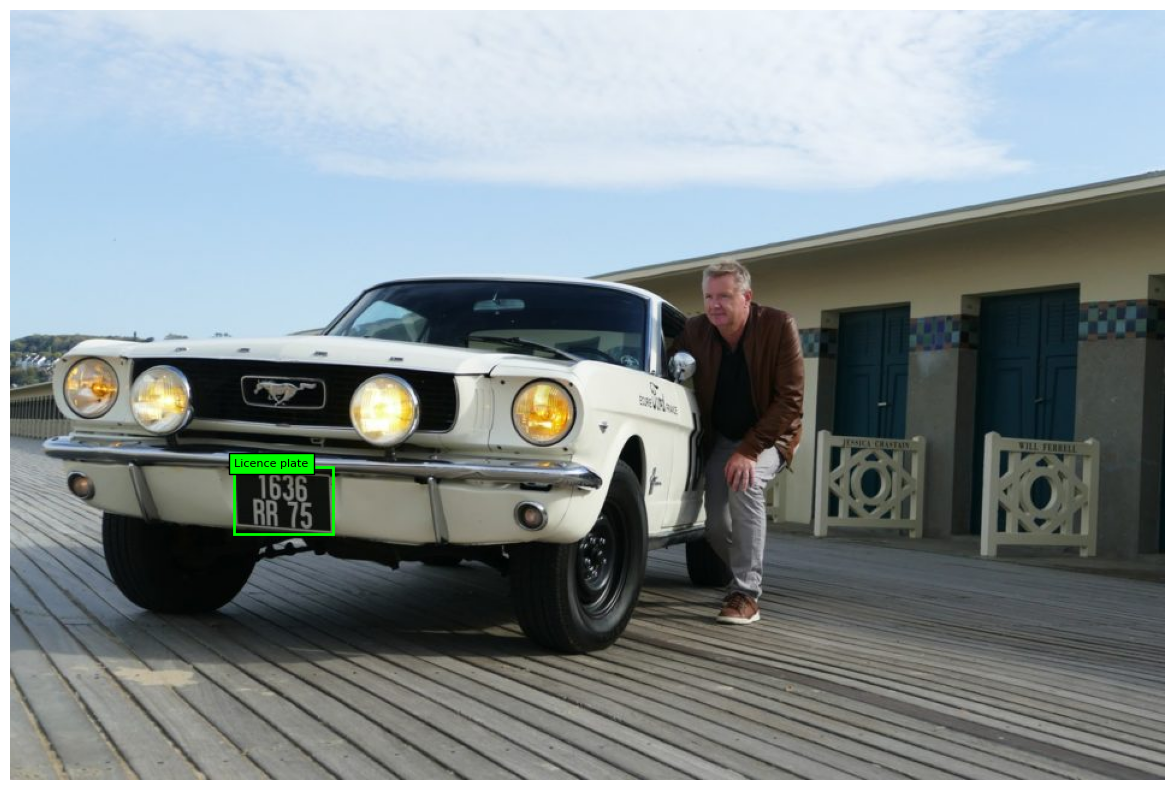

In [ ]:
plot_bbox(image, results['<CAPTION_TO_PHRASE_GROUNDING>'])

### 3.4 Open vocabulary detection

open vocabulary detection can detect both objects and ocr texts.

results format:

{ '\<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[x1, y1, x2, y2], [x1, y1, x2, y2], ...]], 'bboxes_labels': ['label_1', 'label_2', ..],
'polygons': [[[x1, y1, x2, y2, ..., xn, yn], [x1, y1, ..., xn, yn]], ...], 'polygons_labels': ['label_1', 'label_2', ...]
}}

In [ ]:
task_prompt = '<OPEN_VOCABULARY_DETECTION>'

results = florence2(task_prompt, text_input="75")
print("\033[1;31;34m")
print(results)


{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[184.8000030517578, 377.91998291015625, 269.2799987792969, 436.79998779296875]], 'bboxes_labels': ['75'], 'polygons': [], 'polygons_labels': []}}


In [ ]:
bbox_results = convert_to_od_format(results['<OPEN_VOCABULARY_DETECTION>'])
bbox_results

{'bboxes': [[184.8000030517578,
   377.91998291015625,
   269.2799987792969,
   436.79998779296875]],
 'labels': ['75']}

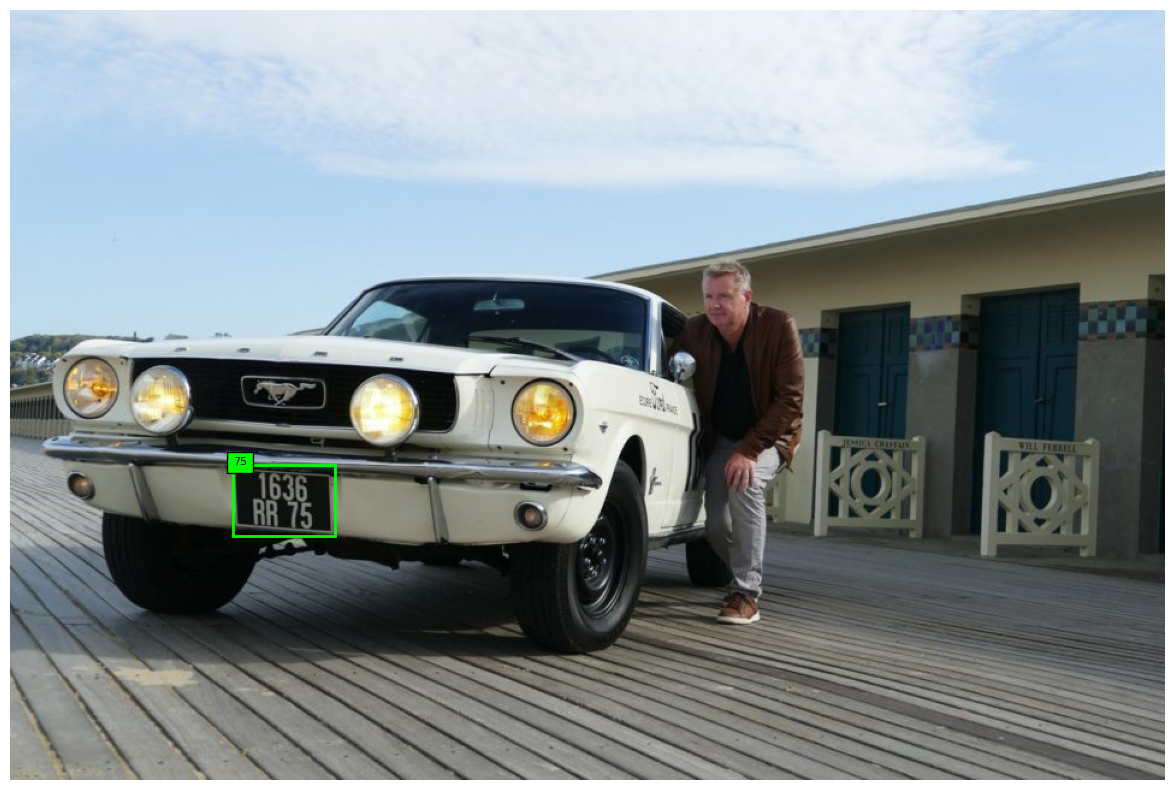

In [ ]:
plot_bbox(image, bbox_results)

### 3.5 Region to texts

In [ ]:
task_prompt = '<REGION_TO_CATEGORY>'

results = florence2(task_prompt,
                    text_input="<loc_52><loc_332><loc_932><loc_774>")
print("\033[1;31;34m")
print(results)


{'<REGION_TO_CATEGORY>': 'car<loc_52><loc_332><loc_932><loc_774>'}


In [ ]:
task_prompt = '<REGION_TO_DESCRIPTION>'

results = florence2(task_prompt,
                    text_input="<loc_52><loc_332><loc_932><loc_774>")
print("\033[1;31;34m")
print(results)


{'<REGION_TO_DESCRIPTION>': 'man posing with white 1965 Ford Mustang on wooden deck<loc_52><loc_332><loc_932><loc_774>'}


## 4. OCR

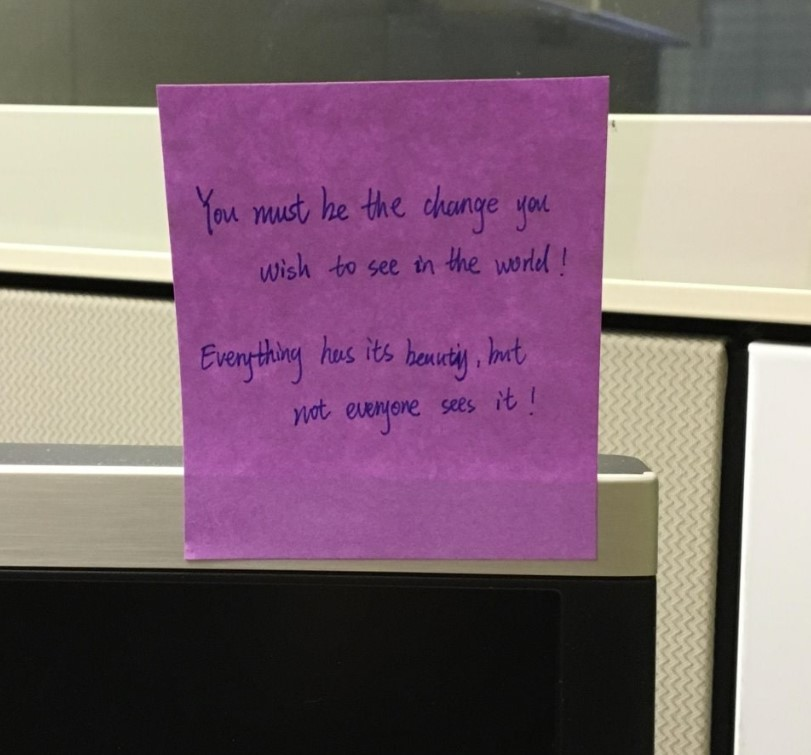

In [ ]:
url = "https://github.com/retkowsky/images/blob/master/OCR.jpg?raw=true"

image = Image.open(requests.get(url, stream=True).raw).convert('RGB')
image

In [ ]:
task_prompt = '<OCR>'

florence2(task_prompt)

{'<OCR>': 'You must be the change youwish to see in the world!Everything has its beauty, butnot everyone sees it!'}

#Region OCR

In [ ]:
task_prompt = '<OCR_WITH_REGION>'

results = florence2(task_prompt)
print("\033[1;31;34m")
print(results)

print(results[task_prompt]['labels'])